In [123]:
%load_ext autoreload
%autoreload 2

train_path = "../../../generateData/unetdata/noisytrain"
test_path = "../../../generateData/unetdata/noisytest"
val_path = "../../../generateData/unetdata/noisyval"
maskTrain_path = "../../../generateData/data/maskTrain"
maskTest_path = "../../../generateData/data/maskTest"
maskVal_path = "../../../generateData/data/maskVal"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
import sys 
sys.path.append('..')

In [125]:
from models.hybrid import Hybrid as Hybrid
from models.hybridSkip import Hybrid as Skip
from models.hybridDoubleSkip import Hybrid as DoubleSkip

import os 

import torch
from torchvision import transforms
import numpy as np

from utils.smileyDataLoader import LandmarksDataset, ToTensor, Rescale, ToTensorSeg1
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from utils.utilsSmiley import scipy_to_torch_sparse, genMatrixesLH

from sklearn import linear_model

In [126]:
from utils.smileyDataLoader import LandmarksDataset, ToTensor, Rescale
img_path = os.path.join(test_path, 'Images')
label_path = os.path.join(test_path, 'landmarks')
test_dataset = LandmarksDataset(img_path=img_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             Rescale([320,256]),
                                             ToTensor()])
                                 )

img_path1 = os.path.join(train_path, 'Images')
label_path1 = os.path.join(train_path, 'landmarks')
train_dataset = LandmarksDataset(img_path=img_path1,
                                 label_path=label_path1,
                                 transform = transforms.Compose([
                                             Rescale([320,256]),
                                             ToTensor()])
                                 )

img_path2 = os.path.join(val_path, 'Images')
label_path2 = os.path.join(val_path, 'landmarks')
Val_dataset = LandmarksDataset(img_path=img_path2,
                                 label_path=label_path2,
                                 transform = transforms.Compose([
                                             Rescale([320,256]),
                                             ToTensor()])
                                 )


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
from utils.smileyDataLoader import LandmarksDataset, ToTensor, Rescale


Total of landmarks: 15
Total of landmarks: 70
Total of landmarks: 15


In [130]:
def extract_features(dataset):
    features = []
    for i in range(len(dataset)):
        features.append(dataset[i]['landmarks'])
    return torch.stack(features)

# Extract features from the datasets
train_features = extract_features(train_dataset)
test_features = extract_features(test_dataset)
val_features = extract_features(Val_dataset)

# Convert features to numpy arrays for compatibility with scikit-learn
train_features = train_features.numpy()
test_features = test_features.numpy()
val_features = val_features.numpy()
print("train_features shape:", train_features.shape)
print("test_features shape:", test_features.shape)
print("val_features shape:", val_features.shape)

train_eyes_features = train_features[:, :2]
test_eyes_features = test_features[:, :2]
val_eyes_features = val_features[:, :2]

train_mouth_features = train_features[:, 2:]
test_mouth_features = test_features[:, 2:]
val_mouth_features = val_features[:, 2:]
print("train_eyes_features shape:", train_eyes_features.shape)
print("test_eyes_features shape:", test_eyes_features.shape)
print("val_eyes_features shape:", val_eyes_features.shape)
print("train_mouth_features shape:", train_mouth_features.shape)
print("test_mouth_features shape:", test_mouth_features.shape)
print("val_mouth_features shape:", val_mouth_features.shape)


# Reshape the features
train_features = train_features.reshape(70, -1)
test_features = test_features.reshape(15, -1)
val_features = val_features.reshape(15, -1)

train_eyes_features = train_eyes_features.reshape(70, -1)
test_eyes_features = test_eyes_features.reshape(15, -1)
val_eyes_features = val_eyes_features.reshape(15, -1)

train_mouth_features = train_mouth_features.reshape(70, -1)
test_mouth_features = test_mouth_features.reshape(15, -1)
val_mouth_features = val_mouth_features.reshape(15, -1)


print("train_features shape:", train_features.shape)
print("test_features shape:", test_features.shape)
print("val_features shape:", val_features.shape)
print("train_eyes_features shape:", train_eyes_features.shape)
print("test_eyes_features shape:", test_eyes_features.shape)
print("val_eyes_features shape:", val_eyes_features.shape)
print("train_mouth_features shape:", train_mouth_features.shape)
print("test_mouth_features shape:", test_mouth_features.shape)
print("val_mouth_features shape:", val_mouth_features.shape)

train_features shape: (70, 14, 2)
test_features shape: (15, 14, 2)
val_features shape: (15, 14, 2)
train_eyes_features shape: (70, 2, 2)
test_eyes_features shape: (15, 2, 2)
val_eyes_features shape: (15, 2, 2)
train_mouth_features shape: (70, 12, 2)
test_mouth_features shape: (15, 12, 2)
val_mouth_features shape: (15, 12, 2)
train_features shape: (70, 28)
test_features shape: (15, 28)
val_features shape: (15, 28)
train_eyes_features shape: (70, 4)
test_eyes_features shape: (15, 4)
val_eyes_features shape: (15, 4)
train_mouth_features shape: (70, 24)
test_mouth_features shape: (15, 24)
val_mouth_features shape: (15, 24)


In [102]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split

testlab = [0,0,0,0,1,0,0,0,1,0,0,1,0,0,0]
trainlab = [0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,1,0,0,1,1,0,0,0,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,1,1,0,1,1,0,0,1,1,1,1,1,0,1,0,0]
valLab = [0,1,1,1,1,1,0,1,1,0,1,1,0,1,0]   

# Convert the labels to pandas Series for compatibility
y_train = pd.Series(trainlab)
y_test = pd.Series(testlab)
y_val = pd.Series(valLab)

print("Number of samples in train_features:", len(val_features))
print("Number of labels in y_train:", len(y_val))
# Create and train the model
model = SVC()
model.fit(train_features, y_train)

# Predict on the test set
y_test_pred = model.predict(test_features)

# Evaluate the model on the test set
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

# Predict on the validation set
y_val_pred = model.predict(val_features)

# Evaluate the model on the validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

# Cross-validation
cv_scores = cross_val_score(model, train_features, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average Cross-Validation Score: {cv_scores.mean()}')


Number of samples in train_features: 15
Number of labels in y_train: 15
Test Accuracy: 1.0
Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         3

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

Validation Accuracy: 1.0
Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        10

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Average Cross-Validation Score: 1.0


In [133]:
model = SVC()
model.fit(train_eyes_features, y_train)

# Predict on the test set
y_eye_test_pred = model.predict(test_eyes_features)

# Evaluate the model on the test set
print("Test Accuracy:", accuracy_score(y_test, y_eye_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_eye_test_pred))

# Predict on the validation set
y_eye_val_pred = model.predict(val_eyes_features)

# Evaluate the model on the validation set
print("Validation Accuracy:", accuracy_score(y_val, y_eye_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_eye_val_pred))

# Cross-validation
cv_scores = cross_val_score(model, train_eyes_features, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average Cross-Validation Score: {cv_scores.mean()}')


Test Accuracy: 0.8
Test Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        12
           1       0.00      0.00      0.00         3

    accuracy                           0.80        15
   macro avg       0.40      0.50      0.44        15
weighted avg       0.64      0.80      0.71        15

Validation Accuracy: 0.3333333333333333
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50         5
           1       0.00      0.00      0.00        10

    accuracy                           0.33        15
   macro avg       0.17      0.50      0.25        15
weighted avg       0.11      0.33      0.17        15

Cross-Validation Scores: [0.57142857 0.57142857 0.5        0.5        0.5       ]
Average Cross-Validation Score: 0.5285714285714286


c:\Users\marie\miniforge3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marie\miniforge3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marie\miniforge3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

In [134]:
model = SVC()
model.fit(train_mouth_features, y_train)

# Predict on the test set
y_mouth_test_pred = model.predict(test_mouth_features)

# Evaluate the model on the test set
print("Test Accuracy:", accuracy_score(y_test, y_mouth_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_mouth_test_pred))

# Predict on the validation set
y_mouth_val_pred = model.predict(val_mouth_features)

# Evaluate the model on the validation set
print("Validation Accuracy:", accuracy_score(y_val, y_mouth_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_mouth_val_pred))

# Cross-validation
cv_scores = cross_val_score(model, train_mouth_features, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average Cross-Validation Score: {cv_scores.mean()}')

Test Accuracy: 1.0
Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         3

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

Validation Accuracy: 1.0
Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        10

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Average Cross-Validation Score: 1.0


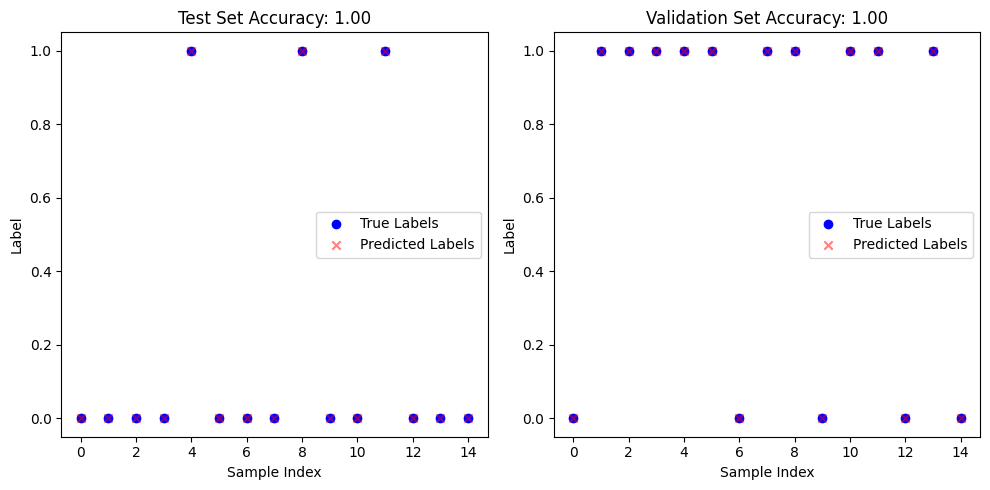

In [105]:
# Plot the results
plt.figure(figsize=(10, 5))

# Plot for test set
plt.subplot(1, 2, 1)
plt.scatter(np.arange(len(y_test)), y_test, color='blue', label='True Labels', marker='o')
plt.scatter(np.arange(len(y_test)), y_test_pred, color='red', alpha=0.5, label='Predicted Labels', marker='x')
plt.title(f'Test Set Accuracy: {accuracy_score(y_test, y_test_pred):.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.legend()

# Plot for validation set
plt.subplot(1, 2, 2)
plt.scatter(np.arange(len(y_val)), y_val, color='blue', label='True Labels', marker='o')
plt.scatter(np.arange(len(y_val)), y_val_pred, color='red', alpha=0.5, label='Predicted Labels', marker='x')
plt.title(f'Validation Set Accuracy: {accuracy_score(y_val, y_val_pred):.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
A, AD, D, U = genMatrixesLH()

A = sp.csc_matrix(A).tocoo()
AD = sp.csc_matrix(AD).tocoo()
D = sp.csc_matrix(D).tocoo()
U = sp.csc_matrix(U).tocoo()

D_ = [D.copy()]
U_ = [U.copy()]
A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]
# Nodes 
N1 = A.shape[0]
N2 = AD.shape[0]

config = {}
config['n_nodes'] = [N1, N1, N1, N2, N2, N2]


A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

config['latents'] = 64
config['inputsize'] = [320,256]

f = 32
config['filters'] = [2, f, f, f, f//2, f//2, f//2]
config['skip_features'] = f

config['window'] = (3,3)

config['K'] = 6
config['l1'] = 5
config['l2'] = 4

double54 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device) # have not done this method yet
# double54.load_state_dict(torch.load("../weights/Skip/double_L54/best.pt"))
double54.load_state_dict(torch.load("../TrainingSave/Smiley12points/noisyFaces500EpocsDoubleSkipNoAugLayer54/bestMSE.pt")) 
double54.eval()
print('Model loaded')

[10, 8]
5-4
Model loaded


In [6]:
config['l1'] = 6
config['l2'] = 5
double65 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
double65.load_state_dict(torch.load("../TrainingSave/Smiley12points/unetnoisyFaces500EpocsDoubleSkipNoAugLayer65/bestMSE.pt"))
double65.eval()
print('Model loaded')

[10, 8]
6-5
Model loaded


In [7]:
config['l1'] = 4
config['l2'] = 3

double43 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
double43.load_state_dict(torch.load("../TrainingSave/Smiley12points/noisyFaces500EpocsDoubleSkipNoAugLayer43/bestMSE.pt"))
double43.eval()
print('Model loaded')

[10, 8]
4-3
Model loaded


In [8]:
hybrid = Hybrid(config, D_t, U_t, A_t).to(device)
hybrid.load_state_dict(torch.load("../TrainingSave/Smiley12points/unetnoisyFaces500EpocsHybridGNetNoAugLayer6/bestMSE.pt"))
hybrid.eval()
print('Model loaded')

Model loaded


In [9]:
config['layer'] = 6

Skip6 = Skip(config, D_t, U_t, A_t).to(device)
Skip6.load_state_dict(torch.load("../TrainingSave/Smiley12points/unetnoisyFaces500Epocs1SkipNoAugLayer6/bestMSE_0.pt"))
Skip6.eval()
print('Model loaded')

Model loaded


In [10]:
config['layer'] = 3

Skip3 = Skip(config, D_t, U_t, A_t).to(device)
Skip3.load_state_dict(torch.load("../TrainingSave/Smiley12points/noisyFaces500Epocs1SkipNoAugLayer3/bestMSE.pt"))
Skip3.eval()
print('Model loaded')

Model loaded


In [11]:
config['layer'] = 4

Skip4 = Skip(config, D_t, U_t, A_t).to(device)
Skip4.load_state_dict(torch.load("../TrainingSave/Smiley12points/noisyFaces500Epocs1SkipNoAugLayer4/bestMSE.pt"))
Skip4.eval()
print('Model loaded')

Model loaded


In [12]:
config['layer'] = 5

Skip5 = Skip(config, D_t, U_t, A_t).to(device)
Skip5.load_state_dict(torch.load("../TrainingSave/Smiley12points/noisyFaces500Epocs1SkipNoAugLayer5/bestMSE.pt"))
Skip5.eval()
print('Model loaded')

Model loaded


In [13]:
from models.unet import UNet

modelUNet = UNet(n_classes = 3).to(device)
modelUNet.load_state_dict(torch.load('../Training/Unet500epochsnoisyTrainingSave/bestDice_0.pt'))
# modelUNet.load_state_dict(torch.load('../Training/Unet100epochsnoisy/bestDice_0.pt'))

modelUNet.eval()
print('Model loaded')

Model loaded


In [14]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# model_list = [hybrid, Skip6, double65]
# model_names = ['HybridGNet', '1-SC Layer 6', '2-SC Layers 6-5']
model_list = [hybrid, Skip3, Skip4, Skip5, Skip6, double43, double54, double65]
model_names = ['HybridGNet', '1-SC Layer 3', '1-SC Layer 4','1-SC Layer 5','1-SC Layer 6', '2-SC Layers 4-3', '2-SC Layers 5-4', '2-SC Layers 6-5']


results1 = pd.DataFrame()

for i in range(0, len(test_dataset.images)):   
    print('\r',i+1,'of', len(test_dataset.images),end='')
    with torch.no_grad():
        sample = test_dataset[i]

        data, target = sample['image'], sample['landmarks']
        print("data, target", data.shape, target.shape)

        data = torch.unsqueeze(data, 0).to(device)
        target =  target[:14,:].reshape(-1).numpy()
        
        for j in range(0, len(model_list)):
            output = model_list[j](data)
            if len(output) > 1:
                output = output[0]
            output = output.cpu().numpy().reshape(-1)
            
            error = mean_squared_error(target * 320, output * 320)
            
            aux = pd.DataFrame([[i, error, model_names[j]]], columns=['i','MSE', 'Model'])
            results1 = results1.append(aux, ignore_index = True)

 1 of 15data, target torch.Size([1, 320, 256]) torch.Size([14, 2])
 2 of 15data, target torch.Size([1, 320, 256]) torch.Size([14, 2])
 3 of 15data, target torch.Size([1, 320, 256]) torch.Size([14, 2])
 4 of 15data, target torch.Size([1, 320, 256]) torch.Size([14, 2])
 5 of 15data, target torch.Size([1, 320, 256]) torch.Size([14, 2])
 6 of 15data, target torch.Size([1, 320, 256]) torch.Size([14, 2])
 7 of 15data, target torch.Size([1, 320, 256]) torch.Size([14, 2])
 8 of 15data, target torch.Size([1, 320, 256]) torch.Size([14, 2])
 9 of 15data, target torch.Size([1, 320, 256]) torch.Size([14, 2])
 10 of 15data, target torch.Size([1, 320, 256]) torch.Size([14, 2])
 11 of 15data, target torch.Size([1, 320, 256]) torch.Size([14, 2])
 12 of 15data, target torch.Size([1, 320, 256]) torch.Size([14, 2])
 13 of 15data, target torch.Size([1, 320, 256]) torch.Size([14, 2])
 14 of 15data, target torch.Size([1, 320, 256]) torch.Size([14, 2])
 15 of 15data, target torch.Size([1, 320, 256]) torch.Siz

MSE
HybridGNet 	1094.043 +- 35.568
1-SC Layer 3 	1071.449 +- 45.323
1-SC Layer 4 	1104.181 +- 49.344
1-SC Layer 5 	1084.943 +- 46.785
1-SC Layer 6 	1107.448 +- 55.432
2-SC Layers 4-3 	1110.063 +- 45.950
2-SC Layers 5-4 	1071.146 +- 29.395
2-SC Layers 6-5 	1082.599 +- 42.236



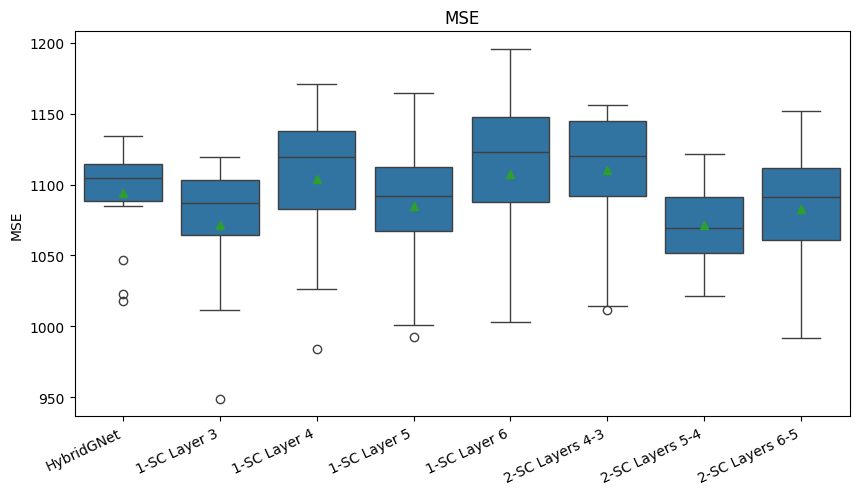

In [15]:
plt.figure(figsize = (10,5))
plt.tight_layout()
sns.boxplot(x = 'Model', y = 'MSE', data = results1, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('MSE')
plt.title('MSE')
plt.xlabel(None)

print('MSE')
for model in model_names:
    print(model, '\t' '%.3f'%np.mean(results1['MSE'][results1['Model'] == model]), '+- %.3f' % np.std(results1['MSE'][results1['Model'] == model]))

print('')

In [16]:
model_names.append('UNet')

In [17]:
aux = results1[results1['Model'] == '2-SC Layers 6-5']
aux0 = aux.sort_values(by = 'MSE')[-3:]
aux0

,i,MSE,Model
47,5,1120.741943,2-SC Layers 6-5
111,13,1125.697998,2-SC Layers 6-5
7,0,1152.148560,2-SC Layers 6-5


masks_sample torch.Size([1, 320, 256]) torch.Size([320, 256])
masks_sample torch.Size([1, 320, 256]) torch.Size([320, 256])
masks_sample torch.Size([1, 320, 256]) torch.Size([320, 256])


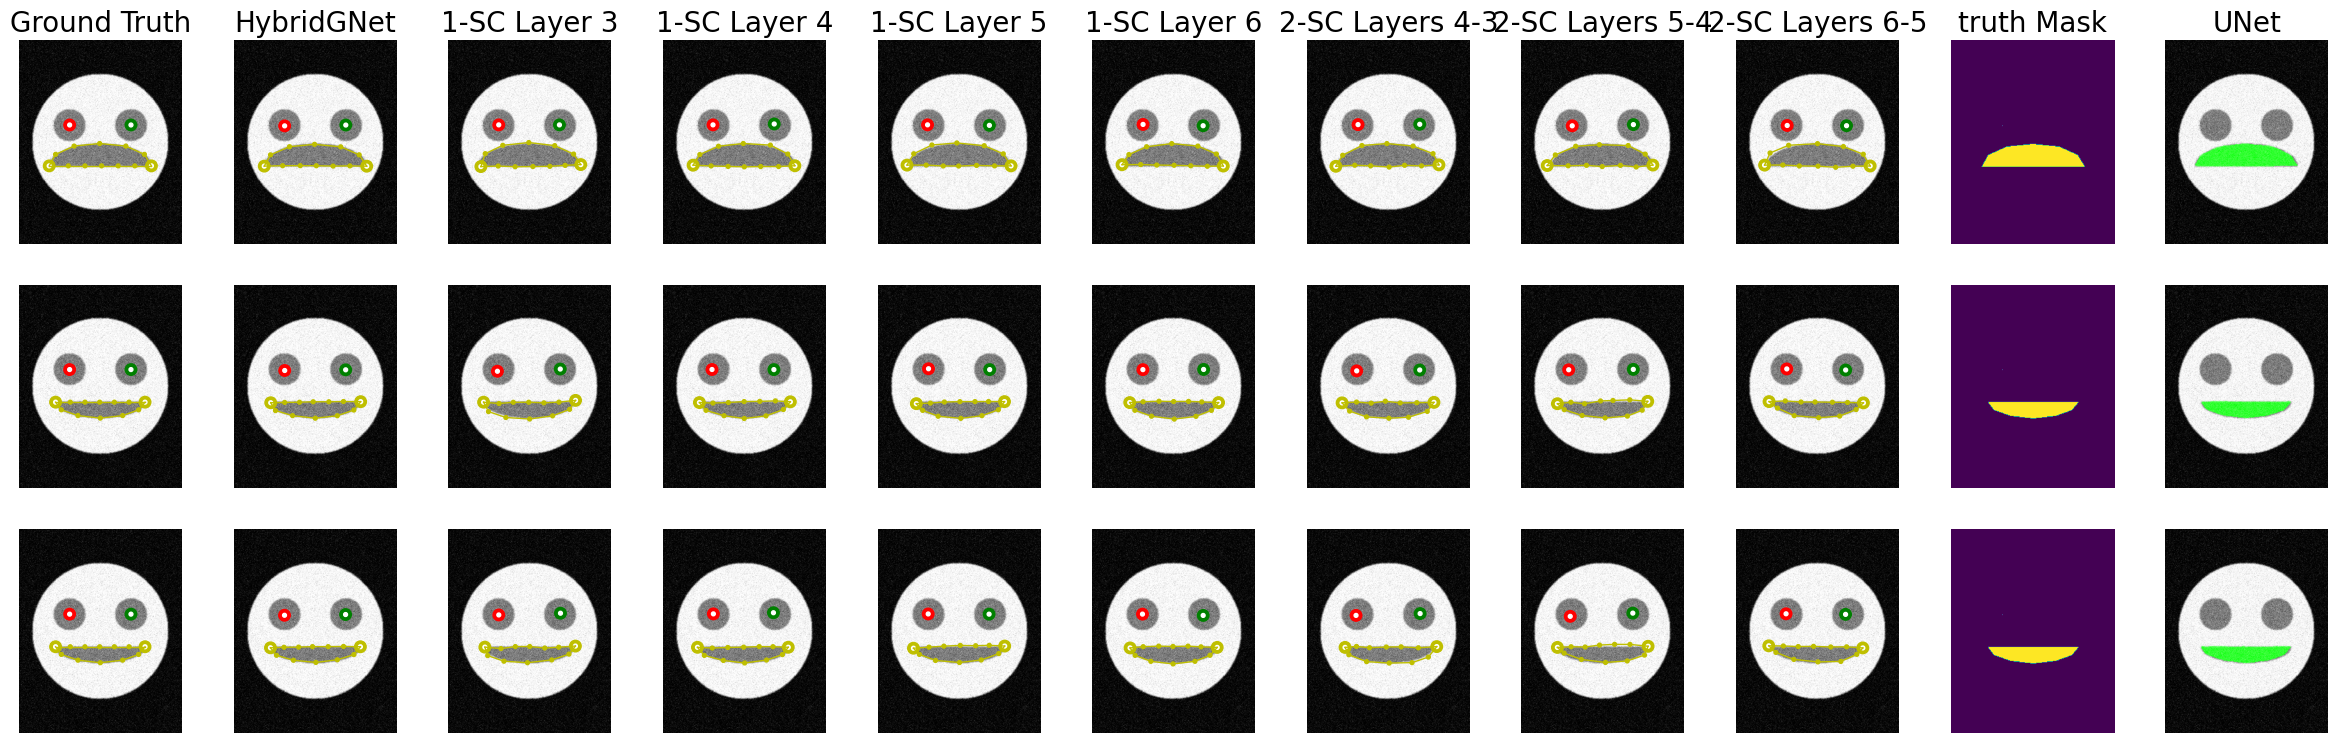

In [18]:
from utils.funSmiley import drawOrgans
from matplotlib import pyplot as plt

model_list_ =[hybrid, Skip3, Skip4, Skip5, Skip6, double43, double54, double65]
model_names_ = ['HybridGNet', '1-SC Layer 3', '1-SC Layer 4','1-SC Layer 5','1-SC Layer 6', '2-SC Layers 4-3', '2-SC Layers 5-4', '2-SC Layers 6-5']


i_ = [4,10,14]
#fig = plt.figure(figsize=(24, 8), dpi= 200)
fig = plt.figure(figsize=(3 * (len(model_list)+2), 9), dpi= 100)

fig.tight_layout()

c = 0
x = 320
y = 256
rows = len(i_)

for i in i_:

    with torch.no_grad():
        
        sample = test_dataset[i]
        cols = len(model_list_) + 3

        data, target = sample['image'], sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target = target.reshape(-1).numpy()

        masks_sample = masktest_dataset[i]
        print("masks_sample", masks_sample['image'].shape, masks_sample['seg'].shape)
        mask_data, mask_target = masks_sample['image'], masks_sample['seg']
        mask_data = torch.unsqueeze(mask_data, 0).to(device)
        mask_target = mask_target.reshape(-1).numpy()

        draw = data.cpu().numpy()[0,0,:,:]
        
        ax = plt.subplot(rows, len(model_list_) + 3, 1 + c * (len(model_list_) + 3))
        plt.axis('off')
        plt.xlim(1, y)
        plt.ylim(x, 1)
        
        target = np.clip(target, 0, 1)
        target = target.reshape(-1, 2)

        if c == 0:
            drawOrgans(ax, target[:28]*x , None, draw.copy())
            plt.title("Ground Truth", fontsize = 20)            # For the first row
        else:
            drawOrgans(ax, target[:28] *x, None, draw.copy())

    
        for j in range(0, len(model_list_)):
            output = model_list_[j](data)
            if len(output) > 1:
                output = output[0]
            output = output.cpu().numpy().reshape(-1) 
            output = np.clip(output, 0, 1)[:28]
            ax = plt.subplot(rows, len(model_list_) + 3, j + 2 + c * (len(model_list_) + 3))
            output = output.reshape(-1, 2)
            plt.axis('off')
            if c == 0:
                drawOrgans(ax, output * [x,y], None, draw.copy())
                plt.title(model_names_[j], fontsize = 20)
            else:
                drawOrgans(ax, output * [x,y], None, draw.copy())

            plt.xlim(1, y)
            plt.ylim(x, 1)
        
        ax = plt.subplot(rows, len(model_list_) + 3, 10 + c * (len(model_list_) + 3))
        if c == 0:
            # plt.imshow(mask_data.cpu().numpy()[0,0,:,:])  # Convert tensor to numpy array and select the first channel of the image
            plt.imshow(mask_target.reshape(320,256))
            plt.title("truth Mask", fontsize = 20)  # For the first row
            plt.axis('off')
        else:
            # plt.imshow(mask_data.cpu().numpy()[0,0,:,:])  # Convert tensor to numpy array and select the first channel of the image
            plt.imshow(mask_target.reshape(320,256))
            plt.axis('off')

        ax = plt.subplot(3, len(model_list_) + 3, j + 4 + c * (len(model_list_) + 3))

        plt.axis('off')

        output = modelUNet(data)
        output = torch.argmax(output[0,:,:,:], axis=0).cpu().numpy()
        ax = plt.subplot(3, len(model_list_) + 3, j + 4 + c * (len(model_list_) + 3))
        ax = plt.subplot
        
        image=np.zeros(list(draw.shape) + [3])
        image[:,:,0] = draw + 0.7 * (output == 1).astype('float') - 0.3 * (output == 2).astype('float')
        image[:,:,1] = draw + 0.7 * (output == 2).astype('float') - 0.2 * (output == 1).astype('float')
        image[:,:,2] = draw - 0.2 * (output == 1).astype('float') - 0.3 * (output == 2).astype('float')
        image = np.clip(image, 0, 1)
        if c == 0:
            plt.title('UNet', fontsize = 20)
        plt.imshow(image)
        plt.xlim(1, y)
        plt.ylim(x, 1)
        
        c += 1
        
# fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.01, hspace=0)      
# plt.savefig('figs/compare_UNet.png', bbox_inches = 'tight', dpi=200)
# plt.savefig('figs/compare_UNet.pdf', bbox_inches = 'tight', dpi=200)

In [116]:
from utils.funSmiley import drawOrgans
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import svm

model_list_ =[hybrid]
model_names_ = ['HybridGNet']

c = 0
x = 320
y = 256

for i in range(len(test_dataset.images)):
    with torch.no_grad():
        sample = test_dataset[i]
        data, target = sample['image'], sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target = target.reshape(-1).numpy()
       
        features = []  # Collect features from each model for this sample
        for model in model_list_:
            output = model(data)
            if isinstance(output, tuple):  # If model returns multiple outputs, select the relevant one
                output = output[0]
            output = output.cpu().numpy().reshape(-1) 
            output = np.clip(output, 0, 1)[:28]  # Clip the output if necessary
            features.append(output)

model = svm.SVC()
model.fit(train_features, y_train)
y_val_pred = model.predict(val_features)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

        


Validation Accuracy: 1.0
Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        10

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [43]:
##Classification

# Load the model
hybridClassification = Hybrid(config, D_t, U_t, A_t).to(device)
hybridClassification.load_state_dict(torch.load("../TrainingSave/Smiley12points/unetnoisyFaces500EpocsHybridGNetNoAugLayer6/final.pt"))
hybridClassification.eval()
print('Model loaded')

# Initialize the SVM
clf = svm.SVC(kernel='linear', C=1)

data = test_dataset[0]['image']
data = torch.unsqueeze(data, 0).to(device)
data = data.cpu().numpy()[0,0,:,:]
target = test_dataset[0]['landmarks']
print("data, target", data.shape, target.shape)


Model loaded
data, target (320, 256) torch.Size([14, 2])


ValueError: y should be a 1d array, got an array of shape (14, 2) instead.

In [27]:
from medpy.metric import dc, hd, assd, jc, asd
from utils.funSmiley import reverseVector, drawBinary

def evalImageMetrics(blank, output, target_lungs, target_heart):
    output = output.cpu().numpy().reshape(-1) 
    # vector = vector.reshape(-1, 1)

    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest = drawBinary(blank.copy(), p1)
    ptest = drawBinary(ptest, p2)
    
    hdp = hd(ptest, target_lungs, voxelspacing = 0.35)
    dcp = dc(ptest, target_lungs)

    #p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest1 = drawBinary(blank.copy(), h)
    
    hdc = hd(ptest1, target_heart, voxelspacing = 0.35)
    dcc = dc(ptest1, target_heart)
    # plt.subplot(1,3,1)
    # plt.imshow(ptest1)
    # plt.subplot(1,3,2)
    # plt.imshow(target_heart)
    # plt.show()

    return [dcp, dcc, hdp, hdc]
    #return [dcp, dcc, hdc]


def evalImageMetricsUNet(output, target_lungs, target_heart):
    dcp = dc(output == 1, target_lungs)
    dcc = dc(output == 2, target_heart)
    #print(target_lungs.shape, target_heart.shape, output.shape)
    #hdp = hd(output == 1, target_lungs, voxelspacing = 0.35)
    hdc = hd(output == 2, target_heart, voxelspacing = 0.35)
        
    # return [dcp, dcc, hdp, hdc]
    return [dcp, dcc, hdc]


In [28]:
blank = np.zeros([320, 256])
x = 320
y = 256
results = pd.DataFrame()

for i in range(0, len(test_dataset.images)):
    print('\r',i+1,'of', len(test_dataset.images),end='')
    with torch.no_grad():
        sample = test_dataset[i]

        data, target = sample['image'], sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target =  target.reshape(-1).numpy()
        print("target", target.shape)
        
        p1, p2, h, c1, c2 = reverseVector(target * x)
       
        t_lungs = drawBinary(blank.copy(), p1)
        t_lungs = drawBinary(t_lungs, p2)
        t_heart = drawBinary(blank.copy(), h)
        
        
        for j in range(0, len(model_list)):
            output = model_list[j](data)
            if len(output) > 1:
                output = output[0]
            output = output.reshape(-1, 2)
            scale = torch.tensor([x,y]).reshape(1,2).to(device)
            # output = output.cpu().numpy().reshape(-1) 
            metrics = evalImageMetrics(blank, output * scale, t_lungs, t_heart)
            print(metrics)
             
            aux = pd.DataFrame([[i, model_names[j]] + metrics], columns=['i','Model','Dice Lungs','Dice Heart','HD Heart','HD Lungs'])
            results = results.append(aux, ignore_index = True)
        
        out = modelUNet(data)[0,:,:,:]
        seg = torch.argmax(out, axis = 0).cpu().numpy()
        metrics = evalImageMetricsUNet(seg, t_lungs, t_heart)
        
        aux = pd.DataFrame([[i, 'UNet'] + metrics], columns=['i','Model','Dice Lungs','Dice Heart','HD Heart'])
        # aux = pd.DataFrame([[i, 'UNet'] + metrics], columns=['i','Model','Dice Lungs','Dice Heart','HD Lungs','HD Heart'])

        results = results.append(aux, ignore_index = True)

 1 of 15target (28,)
[1.0, 0.9644722023139142, 0.0, 0.7826237921249264]
[0.0, 0.9521266073194856, 0.49497474683058323, 1.2619429464123961]
[0.0, 0.9789473684210527, 0.7826237921249264, 0.7826237921249264]
[0.0, 0.9573797172210355, 0.7826237921249264, 1.0499999999999998]
[0.0, 0.9604484584241669, 1.0499999999999998, 1.5652475842498528]
[0.5, 0.9634703196347032, 0.49497474683058323, 1.2619429464123961]
[0.0, 0.9441562404638388, 1.1067971810589325, 1.443086968966181]
[0.0, 0.972562518983497, 1.443086968966181, 1.0499999999999998]
 2 of 15target (28,)
[1.0, 0.9773224358236445, 0.0, 0.49497474683058323]
[0.0, 0.9538779256539697, 0.7826237921249264, 1.0499999999999998]
[0.0, 0.9802525832376578, 0.7826237921249264, 0.35]
[0.0, 0.9572790396610569, 1.0499999999999998, 0.9899494936611665]
[0.5, 0.9597230236583958, 0.7826237921249264, 1.75]
[0.5, 0.9741569127361224, 0.49497474683058323, 0.7]
[0.0, 0.944096550153706, 0.7, 1.4]
[0.0, 0.9490260118978188, 0.7826237921249264, 2.0999999999999996]
 3 of

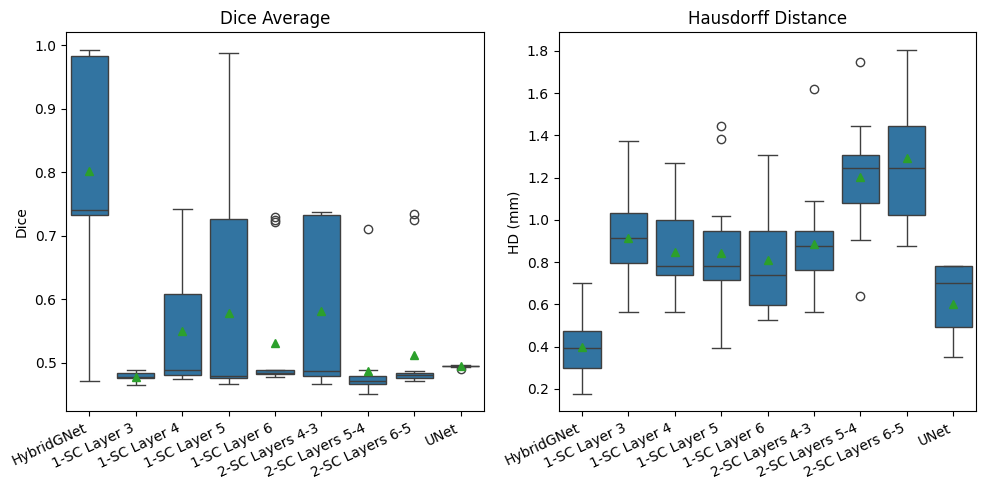

Dice
HybridGNet 0.802 +- 0.172
1-SC Layer 3 0.478 +- 0.007
1-SC Layer 4 0.550 +- 0.110
1-SC Layer 5 0.578 +- 0.157
1-SC Layer 6 0.532 +- 0.097
2-SC Layers 4-3 0.581 +- 0.125
2-SC Layers 5-4 0.487 +- 0.060
2-SC Layers 6-5 0.512 +- 0.085
UNet 0.494 +- 0.001

Hausdorff
HybridGNet 0.399 +- 0.139
1-SC Layer 3 0.916 +- 0.217
1-SC Layer 4 0.850 +- 0.199
1-SC Layer 5 0.845 +- 0.272
1-SC Layer 6 0.812 +- 0.244
2-SC Layers 4-3 0.884 +- 0.244
2-SC Layers 5-4 1.205 +- 0.246
2-SC Layers 6-5 1.292 +- 0.315
UNet 0.603 +- 0.169



In [29]:
import matplotlib.ticker as mticker

results['Dice Average'] = results[['Dice Lungs', 'Dice Heart']].mean(axis=1)
results['HD Average'] = results[['HD Lungs', 'HD Heart']].mean(axis=1)

plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'Dice Average', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice')
plt.title('Dice Average')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD Average', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

plt.tight_layout()
#plt.savefig('figs/num3.png', dpi=300)
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.3f'%np.mean(results['Dice Average'][results['Model'] == model]), '+- %.3f' % np.std(results['Dice Average'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.3f'%np.mean(results['HD Average'][results['Model'] == model]), '+- %.3f' % np.std(results['HD Average'][results['Model'] == model]))

print('')

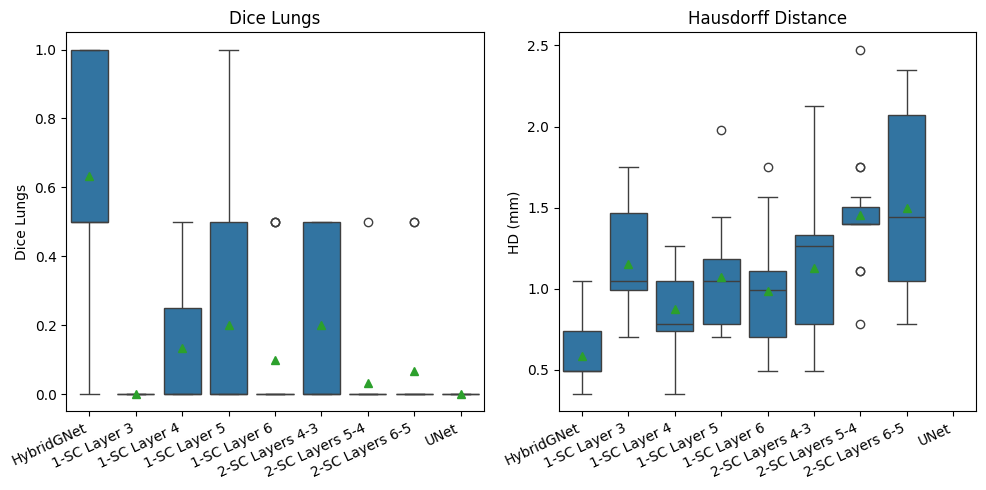

Dice
HybridGNet 0.633 +- 0.340
1-SC Layer 3 0.000 +- 0.000
1-SC Layer 4 0.133 +- 0.221
1-SC Layer 5 0.200 +- 0.306
1-SC Layer 6 0.100 +- 0.200
2-SC Layers 4-3 0.200 +- 0.245
2-SC Layers 5-4 0.033 +- 0.125
2-SC Layers 6-5 0.067 +- 0.170
UNet 0.000 +- 0.000

Hausdorff
HybridGNet 0.588 +- 0.196
1-SC Layer 3 1.151 +- 0.309
1-SC Layer 4 0.876 +- 0.222
1-SC Layer 5 1.071 +- 0.319
1-SC Layer 6 0.987 +- 0.336
2-SC Layers 4-3 1.127 +- 0.389
2-SC Layers 5-4 1.458 +- 0.359
2-SC Layers 6-5 1.497 +- 0.538
UNet nan +- nan



In [30]:
plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'Dice Lungs', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice Lungs')
plt.title('Dice Lungs')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD Lungs', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

plt.tight_layout()
#plt.savefig('figs/num2.png', dpi=300)
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.3f'%np.mean(results['Dice Lungs'][results['Model'] == model]), '+- %.3f' % np.std(results['Dice Lungs'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.3f'%np.mean(results['HD Lungs'][results['Model'] == model]), '+- %.3f' % np.std(results['HD Lungs'][results['Model'] == model]))

print('')

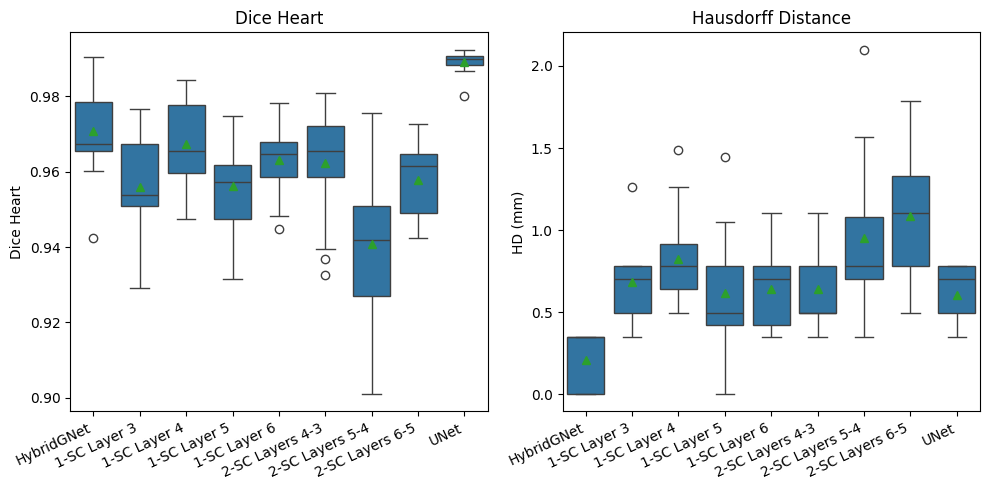

Dice
HybridGNet 0.971 +- 0.012
1-SC Layer 3 0.956 +- 0.014
1-SC Layer 4 0.967 +- 0.011
1-SC Layer 5 0.956 +- 0.013
1-SC Layer 6 0.963 +- 0.009
2-SC Layers 4-3 0.962 +- 0.014
2-SC Layers 5-4 0.941 +- 0.019
2-SC Layers 6-5 0.958 +- 0.010
UNet 0.989 +- 0.003

Hausdorff
HybridGNet 0.210 +- 0.171
1-SC Layer 3 0.681 +- 0.205
1-SC Layer 4 0.824 +- 0.283
1-SC Layer 5 0.618 +- 0.329
1-SC Layer 6 0.638 +- 0.241
2-SC Layers 4-3 0.641 +- 0.195
2-SC Layers 5-4 0.953 +- 0.442
2-SC Layers 6-5 1.086 +- 0.334
UNet 0.603 +- 0.169



In [31]:
plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'Dice Heart', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice Heart')
plt.title('Dice Heart')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD Heart', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

plt.tight_layout()
#plt.savefig('figs/num1.png', dpi=300)
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.3f'%np.mean(results['Dice Heart'][results['Model'] == model]), '+- %.3f' % np.std(results['Dice Heart'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.3f'%np.mean(results['HD Heart'][results['Model'] == model]), '+- %.3f' % np.std(results['HD Heart'][results['Model'] == model]))

print('')

Dice
HybridGNet 0.971 +- 0.012
1-SC Layer 6 0.
2-SC Layers 6-5 0.957 +- 0.010
UNet 0.979 +- 0.011

Hausdorff
HybridGNet 0.210 +- 0.171
1-SC Layer 6 0.638 +- 0.241
2-SC Layers 6-5 1.086 +- 0.334
UNet 1.023 +- 0.371

# Supplementary Results

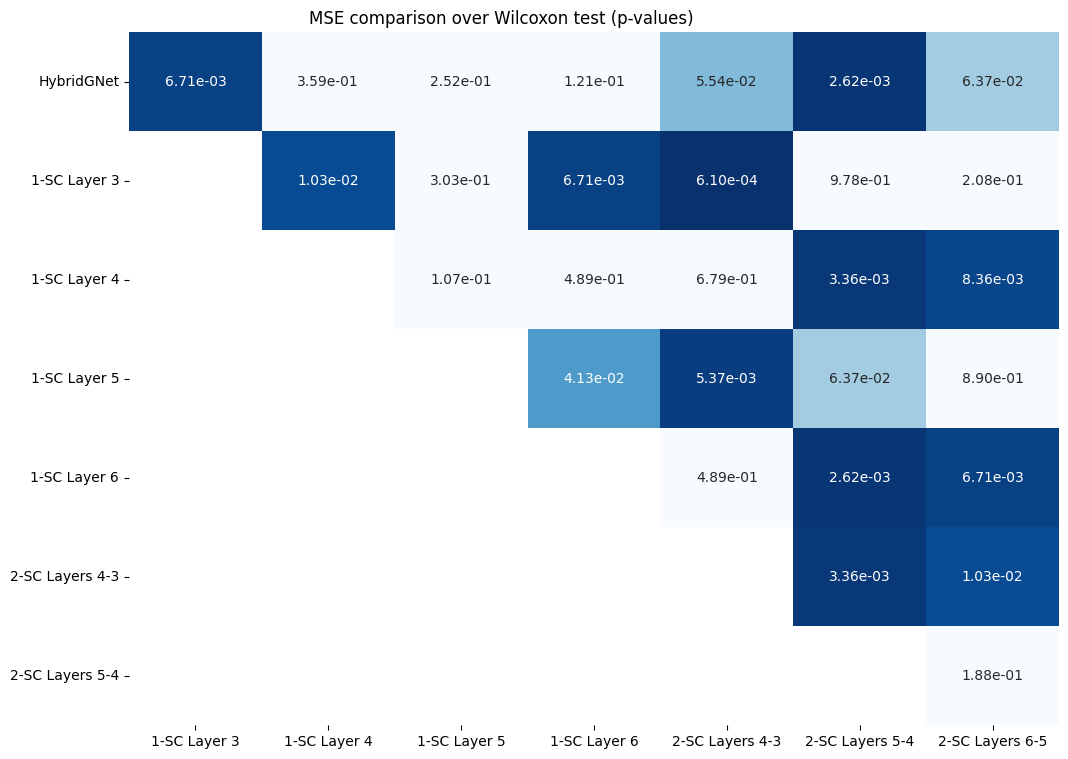

In [235]:
from scipy.stats import wilcoxon

model_names = ['HybridGNet', '1-SC Layer 3', '1-SC Layer 4','1-SC Layer 5','1-SC Layer 6', '2-SC Layers 4-3', '2-SC Layers 5-4', '2-SC Layers 6-5']

nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results1[results1['Model'] == model1]['MSE']
        mse2 = results1[results1['Model'] == model2]['MSE']
        
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]
        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('MSE comparison over Wilcoxon test (p-values)', x = 0.4)

plt.savefig('figs/JSRT_MSE_wilcoxon.png', bbox_inches = 'tight')
plt.show()

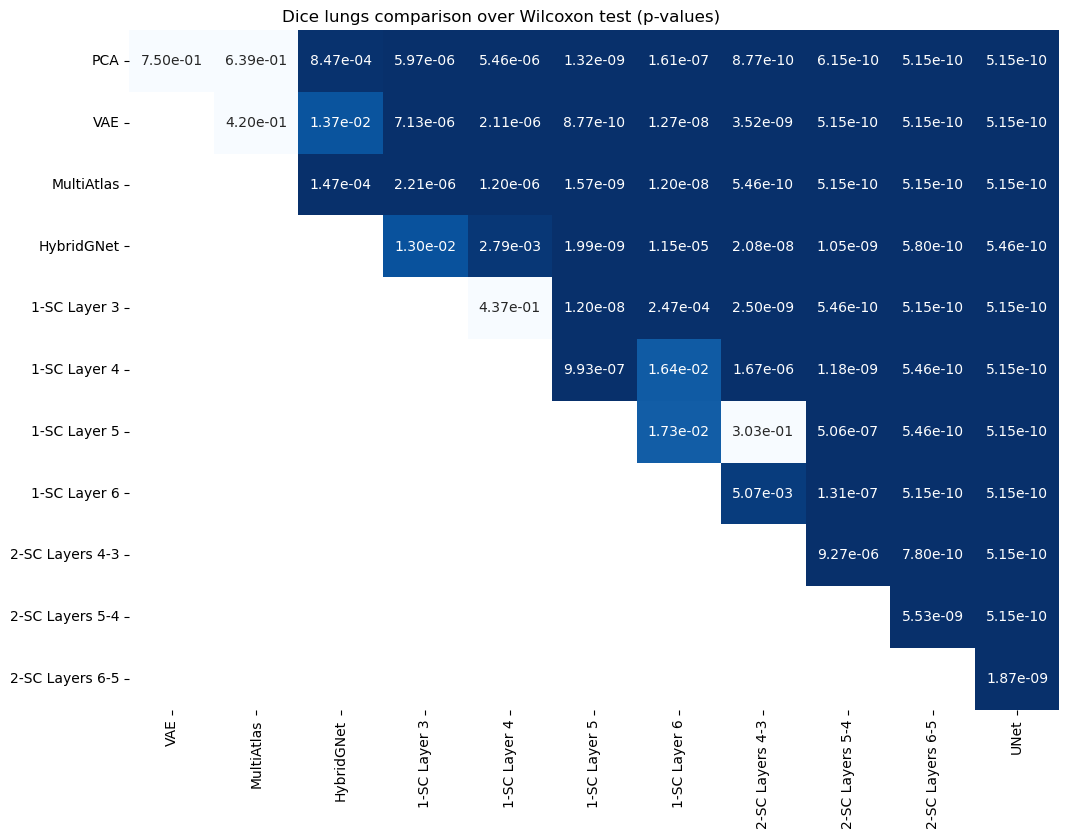

In [30]:
model_names.append('UNet')

nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['Dice Lungs']
        mse2 = results[results['Model'] == model2]['Dice Lungs']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('Dice lungs comparison over Wilcoxon test (p-values)', x = 0.4)

plt.savefig('figs/JSRT_dice_wilcoxon_lungs.png', bbox_inches='tight')
plt.show()

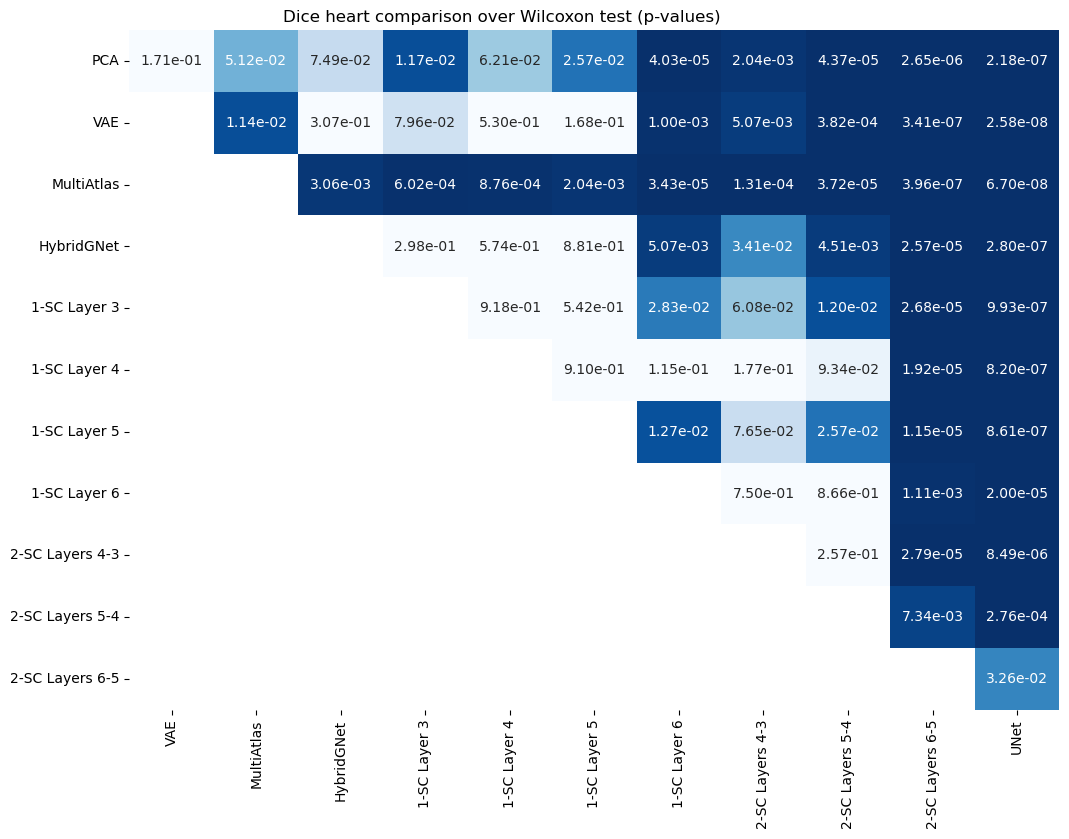

In [31]:
nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['Dice Heart']
        mse2 = results[results['Model'] == model2]['Dice Heart']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('Dice heart comparison over Wilcoxon test (p-values)', x = 0.4)

plt.savefig('figs/JSRT_dice_wilcoxon_heart.png', bbox_inches='tight')
plt.show()

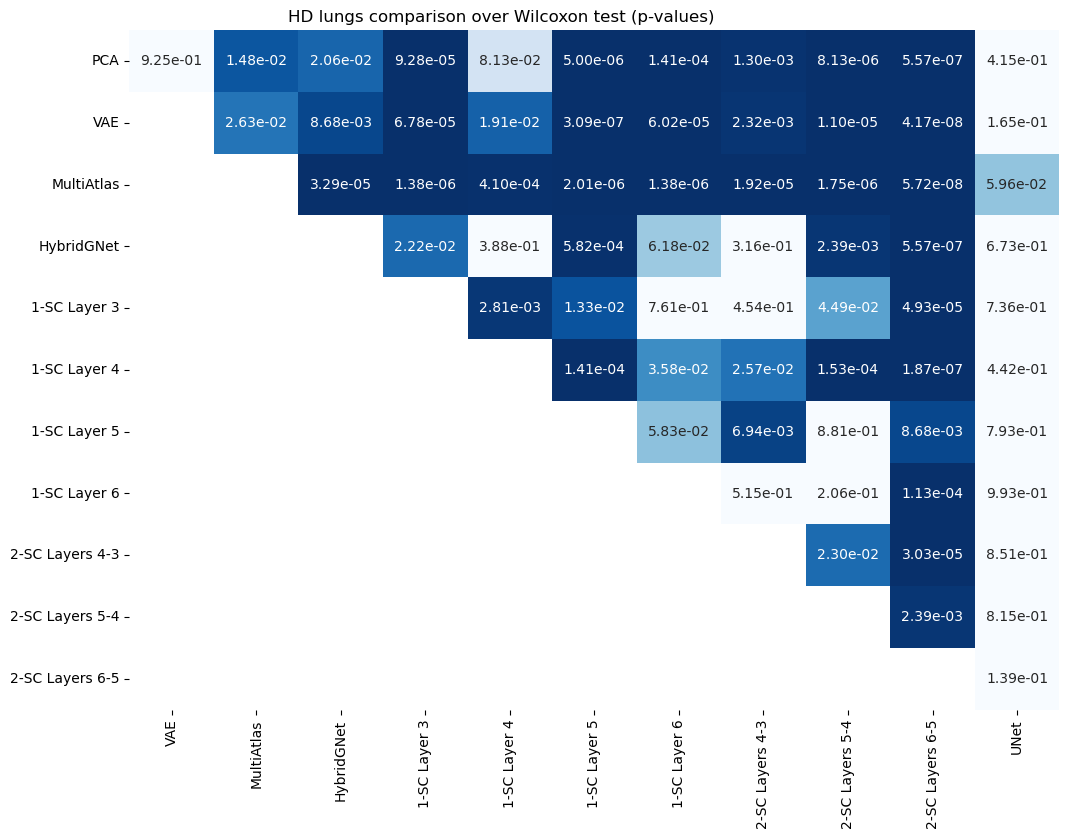

In [32]:
nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['HD Lungs']
        mse2 = results[results['Model'] == model2]['HD Lungs']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('HD lungs comparison over Wilcoxon test (p-values)', x = 0.4)

plt.savefig('figs/JSRT_HD_wilcoxon_lungs.png', bbox_inches='tight')
plt.show()

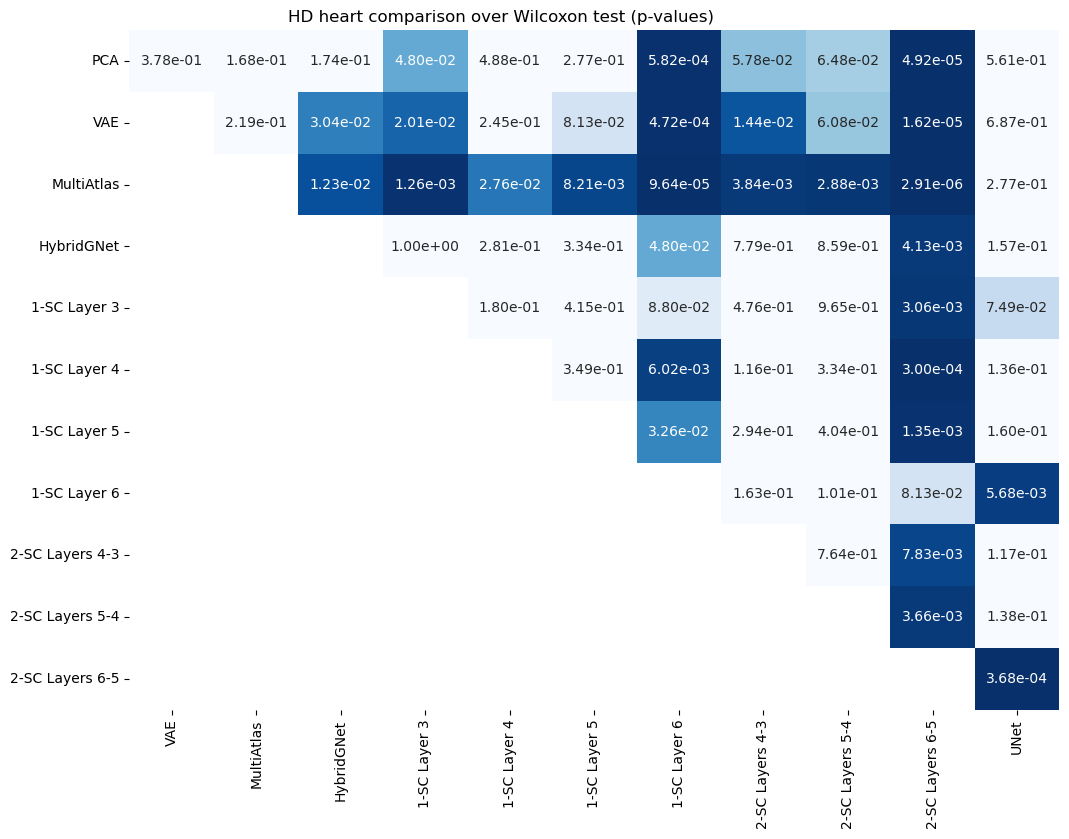

In [33]:
nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['HD Heart']
        mse2 = results[results['Model'] == model2]['HD Heart']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('HD heart comparison over Wilcoxon test (p-values)', x = 0.4)

plt.savefig('figs/JSRT_HD_wilcoxon_heart.png', bbox_inches='tight')
plt.show()